#### SAE图像去噪声

**读取数据集**
+ 读取MNIST数据集
+ 图像转换为$28\times28\times1$
+ 图像的灰度值转换为[0,1]

In [1]:
import numpy as np
import pandas as pd

train_data = pd.read_csv("MNIST_train.csv")
train_images = train_data.iloc[:,1:785].to_numpy()
train_images = train_images.reshape(60000,28,28,1)/255.
test_data = pd.read_csv("MNIST_test.csv")
test_images = test_data.iloc[:,1:785].to_numpy()
test_images = test_images.reshape(10000,28,28,1)/255.

print ("Train Data:", train_images.shape)
print ("Test Data:", test_images.shape)

Train Data: (60000, 28, 28, 1)
Test Data: (10000, 28, 28, 1)


**图像添加噪声**

+ 图像中添加20%强度的噪声
+ 如果灰度值超出[0,1]范围，截断到0和1

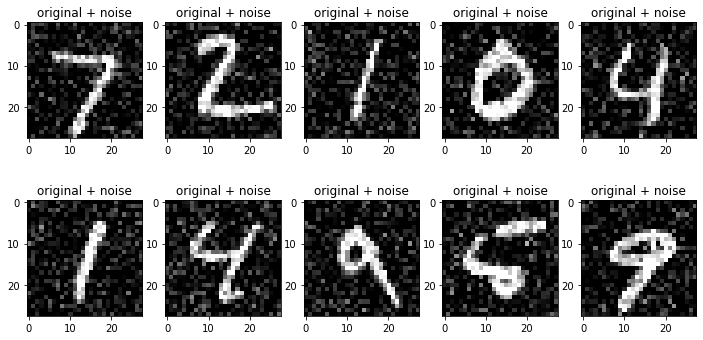

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

noise_factor = 0.2

train_images_noisy = train_images + noise_factor * tf.random.normal(shape=train_images.shape)
test_images_noisy = test_images + noise_factor * tf.random.normal(shape=test_images.shape)

train_images_noisy = tf.clip_by_value(train_images_noisy, clip_value_min=0., clip_value_max=1.)
test_images_noisy = tf.clip_by_value(test_images_noisy, clip_value_min=0., clip_value_max=1.)

plt.figure(figsize=(12, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1); plt.title("original + noise")
    plt.imshow(tf.squeeze(test_images_noisy[i]),cmap='gray')
plt.show()

**构建卷积自编码器**

+ 编码器
    + Input层：输入$28\times 28$图像
    + Conv2D层：$16$个$3\times 3$的卷积核，跨度2
    + Conv2D层：$8$个$3\times 3$的卷积核，跨度2
+ 解码器
    + Conv2D反卷积层：$8$个$3\times 3$的卷积核
    + Conv2D反卷积层：$16$个$3\times 3$的卷积核
    + Conv2D：$1$个$3\times 3$的卷积

In [57]:
from tensorflow.keras import models

autoencoder = models.Sequential()
autoencoder.add(layers.Input(shape=(28, 28, 1)))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))

autoencoder.add(layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'))
autoencoder.add(layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_37 (Conv2D)          (None, 7, 7, 8)           1160      
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 8)        584       
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 16)       1168      
 Transpose)                                                      
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 1)         145       
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-train

**学习网络**
 
+ 以添加噪声的训练集图像作为输入，无噪声的图像作为输出，学习网络
+ 优化方法：Adam
+ 损失函数：MSE
+ 学习10个回合，测试集作为验证观察数据

In [58]:
autoencoder.compile(optimizer='Adam', loss=losses.MeanSquaredError())
autoencoder.fit(train_images_noisy, train_images, epochs=10,shuffle=True,validation_data=(test_images_noisy, test_images))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0158 - val_loss: 0.0041
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.003

**测试网络**

+ 网络输入添加噪声的测试图像
+ 对比输入图像和输出图像

313/313 [==============================] - 1s 2ms/step
(10000, 28, 28, 1)


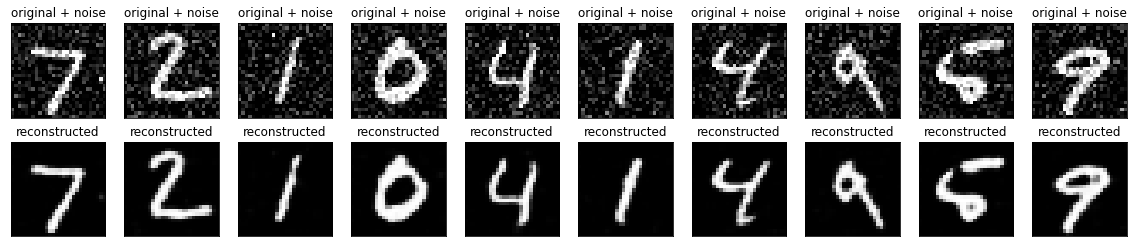

In [62]:
decoded_imgs = autoencoder.predict(test_images_noisy)
print(decoded_imgs.shape)

plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1); plt.title("original + noise")
    plt.imshow(tf.squeeze(test_images_noisy[i]), cmap='gray')
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, 10, i + 10 + 1); plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    bx.get_xaxis().set_visible(False); bx.get_yaxis().set_visible(False)
plt.show()